### Content:
- Train text classifier on custom labels (market sematic)

#### TODO:
- Grid Testing for Parameters
- SpaCy: Find all types of entities in all news articles and store in CSV ("nlp(doc, disable=['parser', 'ner'])")
- NaiveBayes instead of LinearSVC
- Validate features by looking at most important words for each class
- Have a look into Temporal Correlation, ApEN & Cramers V, Hatemining, Related Work Text Classification
- Remove all entities before Vectorizer
- Add pretrained WordEmbedding (e.g. BERT)
- Filename_to_id for reuters and bloomberg

#### Update:
- Replace CountVectorizer mit TfidfVectorizer
- Don't trim to 200 words but by frequency (bag of words may be very large)
- Prepare Data & Write Janna

In [ ]:
from notebook_utils import *
init()

In [16]:
import glob
from datetime import datetime, timedelta
import itertools

from scipy.sparse import issparse
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef, classification_report
import spacy
from spacy import displacy

%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 256 ms


### Load Data

In [7]:
from src.datasets import NyseSecuritiesDataset
from src.datasets import NyseStocksDataset
import src.nlp_utils as nlp_utils
import src.text_classification_utils as tc_utils

HOME = ".."
DATA_DIR = "data"
NEWS = os.path.join(HOME, DATA_DIR, "preprocessed", "news-v3.csv")
OCCS = os.path.join(HOME, DATA_DIR, "preprocessed", "occurrences", "occurrences.csv")
COOCCS = os.path.join(HOME, DATA_DIR, "preprocessed", "occurrences", "cooccurrences.csv")
PRICES = os.path.join(HOME, DATA_DIR, "nyse", "prices-split-adjusted.csv")

stocks_ds = NyseStocksDataset(file_path='../data/nyse/prices-split-adjusted.csv'); stocks_ds.load()
securities_ds = NyseSecuritiesDataset(file_path='../data/nyse/securities.csv'); securities_ds.load()
companies = securities_ds.get_all_company_names()  # List[Tuple[symbol, name]]

occs_per_article = tc_utils.get_occs_per_article(OCCS)


time: 47.8 s


##### Define final test run

In [8]:
# Also contains prices from train for look back
stocks_test_ds = NyseStocksDataset(file_path=PRICES, only_test=True, load=True)
all_news = pd.read_csv(NEWS, index_col=0, skiprows=range(1, 46481))
# news_test = tc_utils.load_news_clipped(stocks_test_ds, look_back=0, forecast=30, file_path=REUTERS)

def final_test(pipe, look_back=0, forecast=30, epsilon_daily_label=0.01, epsilon_overall_label=0.05, min_occurrences=5):
    # 60k articles
    news_test = tc_utils.load_news_clipped(stocks_test_ds, look_back, forecast, news=all_news)
    rel_article_tuples_test = tc_utils.get_relevant_articles(
        news_test, occs_per_article, securities_ds, min_occ=min_occurrences)
    rel_article_tuples_test = [x for x in rel_article_tuples_test
                               if stocks_test_ds.is_company_available(x[0])]

    X_test = np.array([nlp_utils.get_plain_content(x[1]) for x in rel_article_tuples_test])
    y_test = tc_utils.get_discrete_labels(
        rel_article_tuples_test, stocks_test_ds, look_back=look_back, forecast=forecast,
        epsilon_daily_label=epsilon_daily_label, epsilon_overall_label=epsilon_overall_label)
    print('Test distribution:', ''.join([f'"{cls}": {sum(y_test == cls)} samples; ' for cls in [1, -1, 0]]))

    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    return acc, mcc, y_pred


time: 1min 26s


# Grid Tests

In [17]:
EPSILON_DAILY_LABEL = 0.01
EPSILON_OVERALL_LABEL = 0.05
# min_occ->amount_articles:
# 5->15048, 4->18499, 3->23256, 2->30675, 1->45816
MIN_OCCURRENCES = 5  # for one company
MAX_ARTICLES = 20000 # with min_occ=1 we get up to 25k

algorithm = LogisticRegression(random_state=0)
metrics = []
pipes = []

for time_delta in tqdm([x for x in [-100, -50, -30, -10, -5, -1, 1, 5, 10, 30, 50, 100] if x != 0]):
    print('-'*40, '\n', f'time_delta={time_delta}')
    look_back = abs(min(time_delta, 0))
    forecast = abs(max(time_delta, 0))
    pipe, val_acc, val_mcc, train_acc, train_mcc, data = tc_utils.run(
        stocks_ds, securities_ds, occs_per_article, news=all_news, time_delta=time_delta,
        epsilon_daily_label=EPSILON_DAILY_LABEL, epsilon_overall_label=EPSILON_OVERALL_LABEL,
        min_occurrences=MIN_OCCURRENCES, max_articles=MAX_ARTICLES, algorithm=algorithm)
    print('Data shape:', len(data[0]), len(data[1]), len(data[2]), len(data[3]))
    data = None
    gc.collect()
    test_acc, test_mcc, _ = final_test(
        pipe, look_back=look_back, forecast=forecast, epsilon_daily_label=EPSILON_DAILY_LABEL,
        epsilon_overall_label=EPSILON_OVERALL_LABEL, min_occurrences=MIN_OCCURRENCES)

    metrics.append((time_delta, test_acc, test_mcc, val_acc, val_mcc, train_acc, train_mcc))
    pipes.append(pipes)
    gc.collect()

---------------------------------------- 
 time_delta=-100
---------------------------------------- 
 look_back=100; forecast=0


Distribution: "1": 1276 samples; "-1": 1782 samples; "0": 4867 samples; 
Data shape: 6340 6340 1585 1585


Test distribution: "1": 554 samples; "-1": 113 samples; "0": 952 samples; 
---------------------------------------- 
 time_delta=-50
---------------------------------------- 
 look_back=50; forecast=0


Distribution: "1": 2177 samples; "-1": 2823 samples; "0": 3146 samples; 
Data shape: 6516 6516 1630 1630


Test distribution: "1": 965 samples; "-1": 378 samples; "0": 969 samples; 
---------------------------------------- 
 time_delta=-30
---------------------------------------- 
 look_back=30; forecast=0


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Distribution: "1": 2577 samples; "-1": 3050 samples; "0": 2582 samples; 
Data shape: 6567 6567 1642 1642


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Test distribution: "1": 1415 samples; "-1": 970 samples; "0": 612 samples; 
---------------------------------------- 
 time_delta=-5
---------------------------------------- 
 look_back=5; forecast=0


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/home/thomas.kellermeier/nlp-stocks/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Distribution: "1": 1942 samples; "-1": 1987 samples; "0": 4394 samples; 
Data shape: 6658 6658 1665 1665


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Test distribution: "1": 674 samples; "-1": 583 samples; "0": 1881 samples; 


/home/thomas.kellermeier/nlp-stocks/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


---------------------------------------- 
 time_delta=5
---------------------------------------- 
 look_back=0; forecast=5


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Distribution: "1": 2900 samples; "-1": 2965 samples; "0": 2433 samples; 
Data shape: 6638 6638 1660 1660


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Distribution: "1": 3158 samples; "-1": 3369 samples; "0": 1700 samples; 
Data shape: 6581 6581 1646 1646


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Test distribution: "1": 1268 samples; "-1": 919 samples; "0": 951 samples; 
---------------------------------------- 
 time_delta=50
---------------------------------------- 
 look_back=0; forecast=50


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Distribution: "1": 1170 samples; "-1": 1551 samples; "0": 4260 samples; 


/home/thomas.kellermeier/nlp-stocks/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Data shape: 5584 5584 1397 1397


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



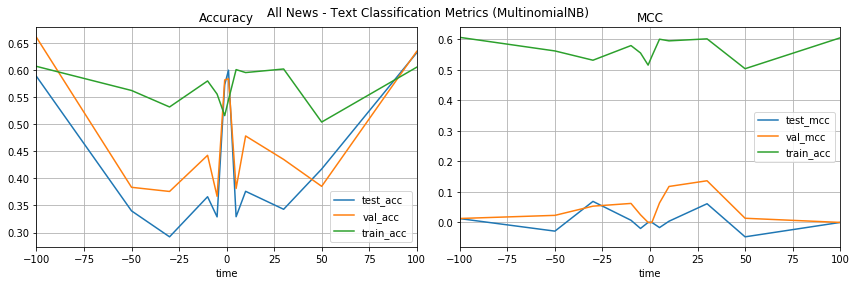

time: 1.59 s


In [18]:
metrics_df = pd.DataFrame(metrics, columns=['time', 'test_acc', 'test_mcc', 'val_acc', 'val_mcc', 'train_acc', 'train_mcc']).set_index('time')
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
metrics_df[['test_acc', 'val_acc', 'train_acc']].plot(ax=axes[0], title='Accuracy', grid=True)
metrics_df[['test_mcc', 'val_mcc', 'train_acc']].plot(ax=axes[1], title='MCC', grid=True)
fig.suptitle('All News - Text Classification Metrics (MultinomialNB)')
fig.tight_layout()
fig.savefig('all-news-test-classification-metrics-lr-mo5.pdf')

# TODO:
- Plot with acc & val_acc for features from 50 to 5000D (https://nlp.stanford.edu/pubs/glove.pdf)
- Show misleading improvement by split_after_shuffle=True (will fail von the test set)

Tutorial: https://towardsdatascience.com/machine-learning-for-text-classification-using-spacy-in-python-b276b4051a49

### General Setting
- Use {LOOK_BACK} last days until open of the {FORECAST} day in the future (for articles on weekends go back to friday)
- Articles from NYSE start 2010-03-22 to Reuters end 2012-12-31 [not touched final test set will be 2013-01-01 to 2013-11-20 with 3901-2803=1098 articles]
- Only use title and real body (with some exceptions because of regex failure)
- TODO: Don't remove numbers, links, special characters from vectorizer

### Experiment 1
- LOOK_BACK = 30
- FORECAST = 0
- EPSILON_DAILY_LABEL = 0.01
- EPSILON_OVERALL_LABEL = 0.05
- Label "1": 829 samples, Label "-1": 1017 samples, Label "0": 957 samples
- Train: 2242 out of 2803 shuffled samples (Test: 561 samples)
- LinearSVC warns: "ConvergenceWarning: Liblinear failed to converge, increase the number of iterations."
- $val\_accuray=0.5$
- $val\_mcc=0.25$

##### Experiment 2:
- Tried calculating the mean of the relative diffs -> Values are very close to zero.
- Therefore stick to the previous method. Calculate daily label and take the mean label.

##### Experiment 3:
- LOOK_BACK=7
- Label "1": 991 labels
- Label "-1": 1106 labels
- Label "0": 706 labels
- $val\_accuray: 0.50$
- $val\_mcc: 0.23$

##### Experiment 4:
- LOOK_BACK=3
- Label "1": 834 labels, Label "-1": 920 labels, Label "0": 1049 labels
- $val\_accuray: 0.41$
- $val\_mcc: 0.11$

##### Experiment 5:
- LOOK_BACK=1
- Label "1": 620 labels,  Label "-1": 653 labels,  Label "0": 1530 labels
- $val\_accuray: 0.47$
- $val\_mcc: 0.12$

##### Experiment 6:
- LOOK_BACK=60
- Label "1": 559 labels, Label "-1": 835 labels, Label "0": 1323 labels
- $val\_accuray: 0.56$
- $val\_mcc: 0.30$

##### Experiment 7:
- LOOK_BACK=0, FORECAST=30
- Label "1": 853 labels, Label "-1": 1031 labels, Label "0": 985 labels
- $val\_accuracy: 0.56$
- $val\_mcc: 0.34$
